<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_Conv1D_%2B_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используем базу трафика сайта компании.

Напишем модель для прогнозирования трафика.

Надо добиться максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [ ]:
#import autokeras as ak
import pandas as pd
import numpy as np
import scipy.stats as stats
import gdown
import random
from tensorflow.keras import utils
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, OneHotEncoder # Нормировщики
from tensorflow.keras.callbacks import LearningRateScheduler # Коллбэк
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Генератор выборки временных рядов
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # Отключение предупреждений

In [ ]:
#Загружаем базу трафика с сайта компании
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/traff.csv', None, quiet=True)

'traff.csv'

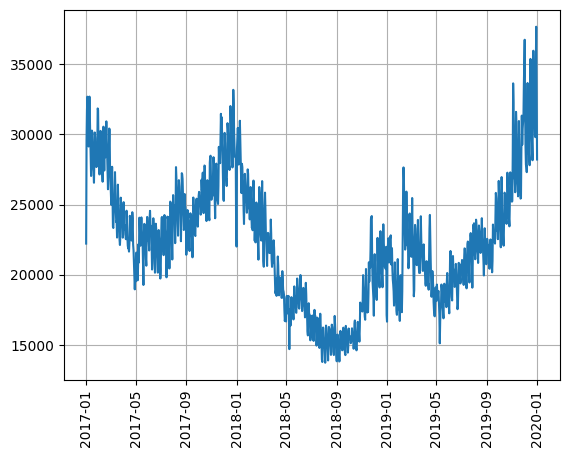

In [ ]:
df = pd.read_csv('traff.csv', header = None)
df[0] = pd.to_datetime(df[0])
df[1] = df[1].str.replace(',', '')
df[1] = df[1].str.replace('.00', '').astype(int)
df = df[df[1]>100]  # очистка данных

plt.plot(df[0],df[1])
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
# обогащение данных
df.columns = ['date', 'traffic']
df['day_of_week'] = df['date'].dt.weekday.astype(int)
df['day_of_month'] = df['date'].dt.day.astype(int)
df['day_of_year'] = df['date'].dt.dayofyear.astype(int)
df['week_of_month'] = (df['date'].dt.day - 1) // 7 + 1
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['month_of_year'] = df['date'].dt.month.astype(int)

df['diff_traff'] = df['traffic'].diff()
df['double_diff_traff'] = df['diff_traff'].diff()
df['inv_traff'] = 1/df['traffic']
df = df.dropna()

df = df.set_index('date')
data = df.to_numpy()
df

,traffic,day_of_week,day_of_month,day_of_year,week_of_month,week_of_year,month_of_year,diff_traff,double_diff_traff,inv_traff
date,,,,,,,,,,
2017-01-03,31726,1,3,3,1,1,1,2133.0,-5234.0,0.000032
2017-01-04,32684,2,4,4,1,1,1,958.0,-1175.0,0.000031
2017-01-05,31820,3,5,5,1,1,1,-864.0,-1822.0,0.000031
2017-01-06,29354,4,6,6,1,1,1,-2466.0,-1602.0,0.000034
2017-01-07,29139,5,7,7,1,1,1,-215.0,2251.0,0.000034
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,29801,4,27,361,4,52,12,-63.0,1517.0,0.000034
2019-12-28,34913,5,28,362,4,52,12,5112.0,5175.0,0.000029
2019-12-29,37665,6,29,363,5,52,12,2752.0,-2360.0,0.000027


In [ ]:
# Задание гиперпараметров

CHANNEL_X = list(df)                 # Отбор каналов входных данных
CHANNEL_Y = ['traffic']                     # Отбор каналов данных для предсказания
SEQ_LEN = 60                             # Длина прошедших данных для анализа
HOLE = 20                               # Защитный интервал между данными
BATCH_SIZE = 5                           # Объем батча для генератора
TEST_LEN = 150                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

In [ ]:
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_X)}

# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + HOLE:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')
# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [0]
Train data: (917, 10), (917, 1)
Test  data: (130, 10), (130, 1)
Train batch x: (5, 60, 10), y: (5, 1)
Test x: (70, 60, 10), y: (70, 1)


In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и денормализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled


# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]


# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()


# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''): # список имен каналов данных

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()


# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=100, back_steps_max=30, # параметры отображения графиков
             title=''):

    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max, title=f'{title}Корреляционные коэффициенты по шагам смещения')


# Функция обучения модели и отрисовки прогресса и оценки результатов

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=100,
                   back_steps_max=30,
                   title=''):

    # Отображение сводки модели
    #model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=0)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

Обучение 1000 эпох


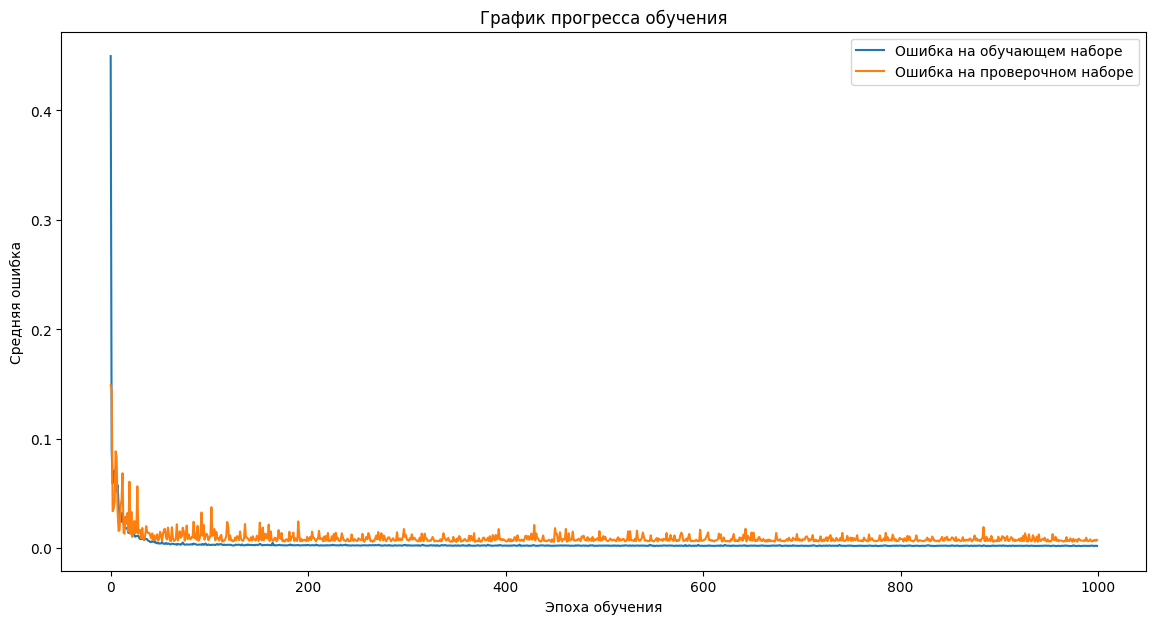

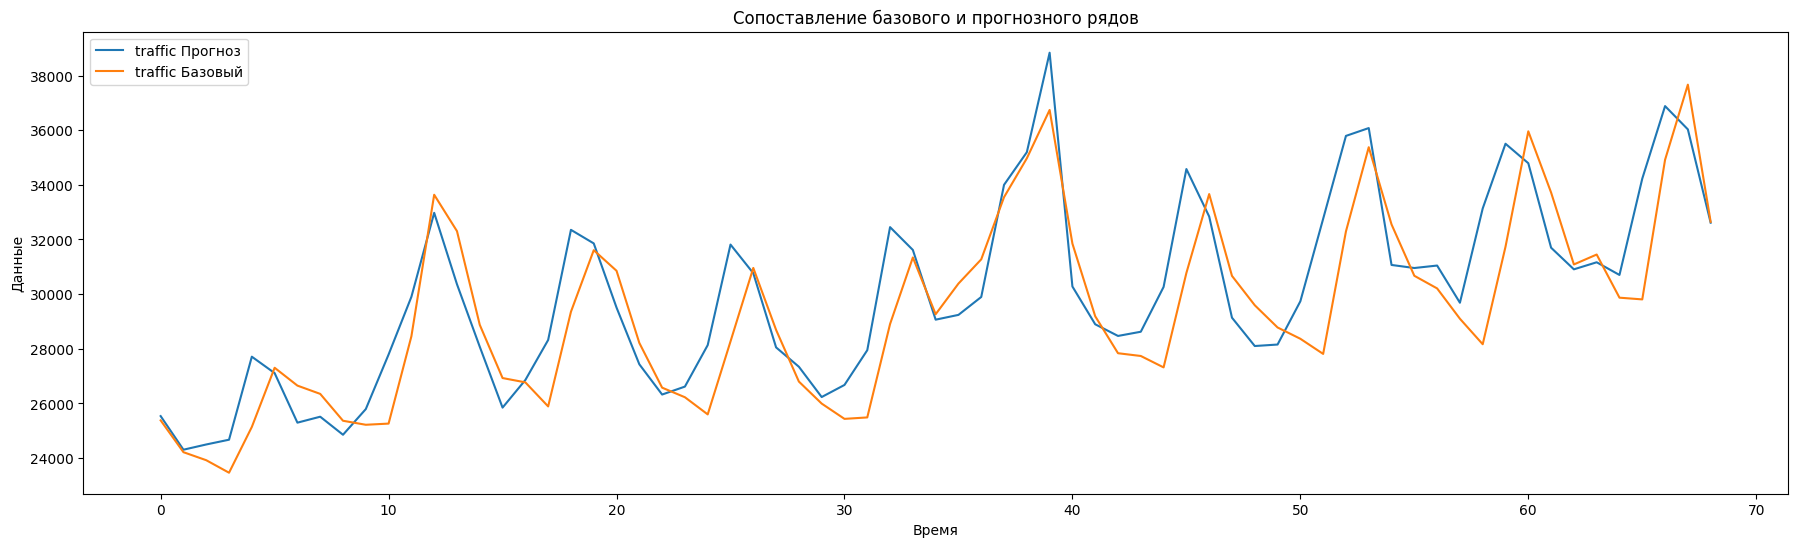

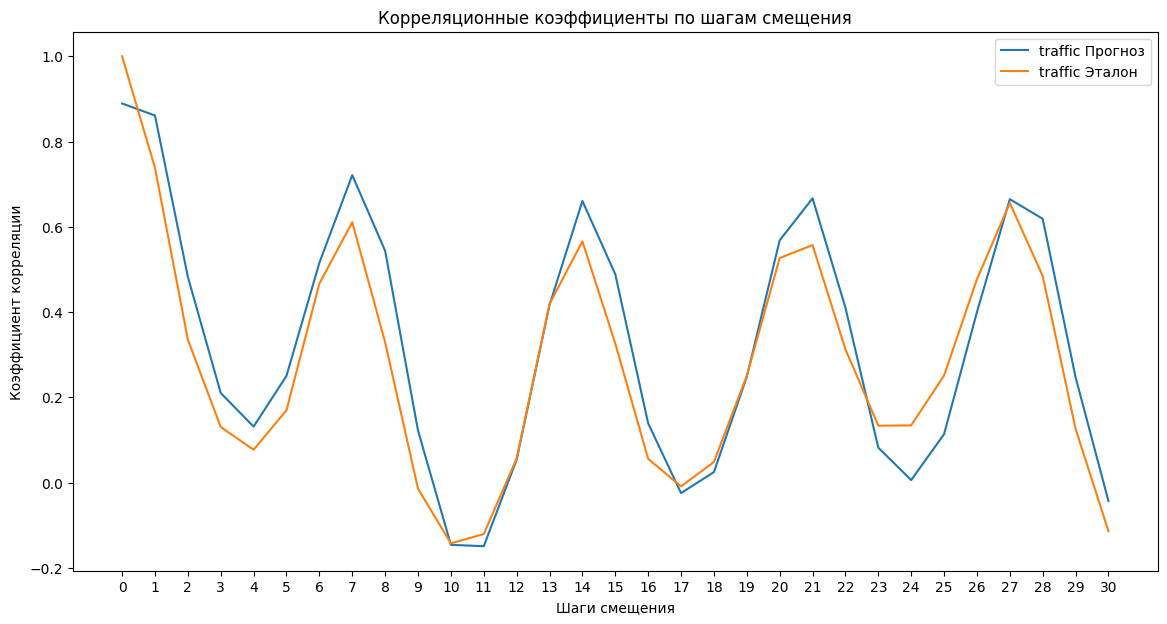

In [ ]:
# модель, обучение и проверка
model = Sequential()
model.add(Conv1D(512, 3, input_shape=x_test.shape[1:], activation='linear'))
model.add(Conv1D(256, 7, activation='linear'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='linear'))
model.add(Dense(y_test.shape[1], activation='linear'))

train_eval_net(model, train_datagen, val_datagen, [(1000, Adam(learning_rate=1e-4))], x_test, y_test, y_scaler)